In [35]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from src.ferbo import Ferbo
from src.gatemonium import Gatemonium
from src.gatemon import Gatemon
from src.andreev import Andreev
from tqdm.notebook import tqdm
from matplotlib.ticker import FuncFormatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import scqubits as scq
fluxonium = scq.Fluxonium(EJ=4.0, EC=3.0, EL=0.5, flux=0.2, cutoff=100)
# zero_pi = scq.Circuit()
transmon = scq.Transmon(EJ=40.0, EC=0.2, ng=0.0, ncut=30)
transmon.plot_n_wavefunction
# fluxonium.anharmonicity
# fluxonium.plot_matrixelements(operator="n_operator", evals_count=4)
# p = fluxonium.get_matelements_vs_paramvals(operator="n_operator", param_name='flux', param_vals=np.linspace(0, 1, 100), evals_count=2)

# 1. Ferbo qubit

In [36]:
Ec, El, Gamma, delta_Gamma, er, phase =  5, 0.12, 10, 0, 0.5, 0
dimension = 80
ferbo = Ferbo(Ec, El, Gamma, delta_Gamma, er, phase=phase, dimension=dimension, flux_grouping="ABS")

## 1.1. Matrix elements

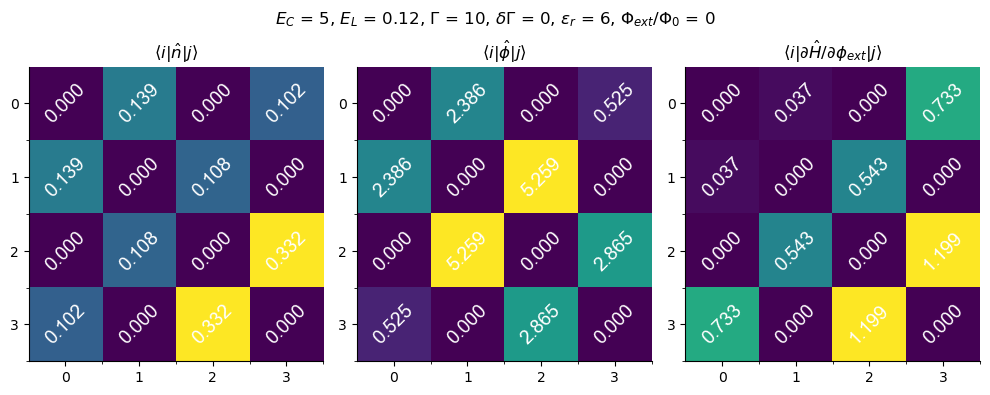

In [120]:
operators = ['n_operator', 'phase_operator','d_hamiltonian_d_phase']
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.suptitle(ferbo._generate_suptitle(), y=0.85)  # Ajusta el valor de y según sea necesario
for idx, operator in enumerate(operators):
    ferbo.plot_matrixelements(operator=operator,evals_count=4, show_numbers=1, fig_ax=(fig, ax[idx]), show3d=False, show_colorbar=False)
    ax[idx].set_title(rf'$ \langle i | {ferbo.OPERATOR_LABELS[operator]} | j \rangle$')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el rect para dejar espacio al suptitle
plt.show()

## 1.2. Potential

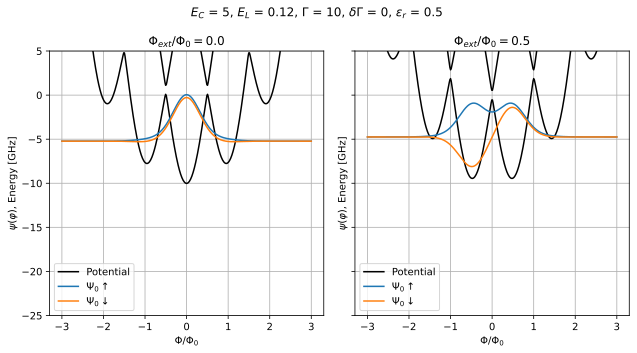

In [40]:
phi_array =np.linspace(-6*np.pi, 6*np.pi, 400)
fig,ax = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey=True)
fig.suptitle(ferbo._generate_suptitle('phase'))
phases = [0, np.pi]
for idx, phase in enumerate(phases):
    ferbo.phase = phase
    ferbo.plot_wavefunction(which=[0], phi_grid=phi_array, scaling=8, fig_ax=(fig, ax[idx]), basis='phase')
    ax[idx].set_title(rf'$\Phi_{{ext}}/\Phi_0 = {phase/2/np.pi}$')
    ax[idx].set_ylim([-25,5])
fig.tight_layout()
plt.show()

## 1.3. Sweep 1D

In [8]:
param_name = 'phase'
param_array = np.linspace(-2*np.pi, 2*np.pi, 201)
evals_count = 7
operators = ['n_operator', 'phase_operator', 'd_hamiltonian_d_phase', 'displacement_operator']
spectrum_data_ferbo = ferbo.get_matelements_vs_paramvals(operators, param_name, param_array, evals_count=evals_count)
spectrum_data_ferbo = ferbo.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_ferbo)
spectrum_data_ferbo = ferbo.get_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_ferbo)

  0%|          | 0/201 [00:00<?, ?it/s]

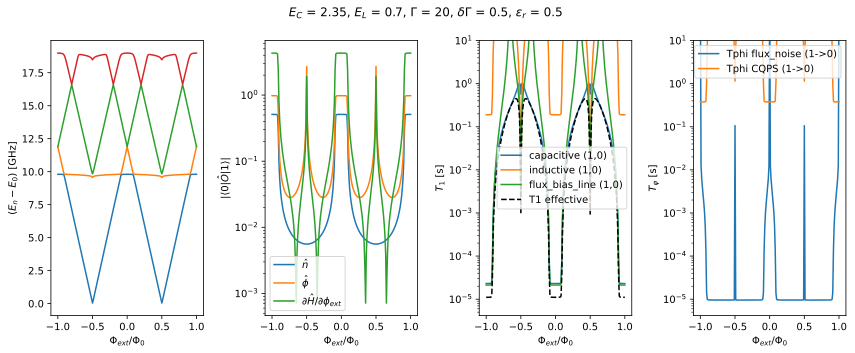

In [10]:
subtract_ground = 1

fig, ax = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle(ferbo._generate_suptitle(exclude_params=param_name))
ferbo.plot_evals_vs_paramvals(spectrum_data=spectrum_data_ferbo, subtract_ground=subtract_ground, fig_ax=(fig, ax[0]), evals_count=4)
ferbo.plot_matelem_vs_paramvals(operator='n_operator', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[1]))
ferbo.plot_matelem_vs_paramvals(operator='phase_operator', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[1]))
ferbo.plot_matelem_vs_paramvals(operator='d_hamiltonian_d_phase', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[1]))
ferbo.plot_t1_vs_paramvals(noise_channels=['capacitive', 'inductive', 'flux_bias_line'], spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[2]))
ferbo.plot_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[3]))

ax[1].set_ylabel(r'$|\langle 0 | \hat{O}| 1 \rangle|$')
ax[1].legend([r'$\hat{n}$', r'$\hat{\phi}$', r'$\partial \hat{H}/\partial \phi_{ext}$'])

if subtract_ground:
    ax[0].set_ylabel(r'$(E_n - E_0)$ [GHz]')
else:
    ax[0].set_ylabel(r'$E_n$ [GHz]')

for i in range(1, 4):
    ax[i].set_yscale('log')

# Set the same ylim for ax[2] and ax[3]
ylim_min = min(ax[2].get_ylim()[0], ax[3].get_ylim()[0])
ylim_max = min(max(ax[2].get_ylim()[1], ax[3].get_ylim()[1]), 1e1)
ax[2].set_ylim(ylim_min, ylim_max)
ax[3].set_ylim(ylim_min, ylim_max)

fig.tight_layout()
plt.show()

### 1.1.4. Sweep 2D

In [ ]:
er_values = np.linspace(0.05, 2, 30)  
delta_Gamma_values = np.linspace(0.05, 2, 30) 
operators = ['n_operator', 'phase_operator', 'd_hamiltonian_d_phase']
E0_array = np.empty((len(er_values), len(delta_Gamma_values)))
E1_array = np.empty((len(er_values), len(delta_Gamma_values)))
E2_array = np.empty((len(er_values), len(delta_Gamma_values)))
n_array = np.empty((len(er_values), len(delta_Gamma_values)), dtype=complex)
phase_array = np.empty((len(er_values), len(delta_Gamma_values)), dtype=complex)
dH_dphi_array = np.empty((len(er_values), len(delta_Gamma_values)), dtype=complex)
t1_cap_array = np.empty((len(er_values), len(delta_Gamma_values)))
t1_ind_array = np.empty((len(er_values), len(delta_Gamma_values)))
t1_flux_array = np.empty((len(er_values), len(delta_Gamma_values)))
t1_effective_array = np.empty((len(er_values), len(delta_Gamma_values)))

initial_param = ferbo.er

for idx,er in enumerate(tqdm(er_values,leave=True)):
    ferbo.set_param('er', er)
    param_name = "delta_Gamma"  # Reemplaza con el nombre del parámetro que deseas variar
    spectrum_data_gatemonium = ferbo.get_matelements_vs_paramvals(operators, param_name, delta_Gamma_values, evals_count=evals_count)
    spectrum_data_gatemonium = ferbo.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium)
    E0_array[idx] = spectrum_data_gatemonium.energy_table[:,0]
    E1_array[idx] = spectrum_data_gatemonium.energy_table[:,1]
    E2_array[idx] = spectrum_data_gatemonium.energy_table[:,2]
    t1_cap_array[idx] = spectrum_data_gatemonium.t1_table['capacitive'][:,0,1]
    t1_ind_array[idx] = spectrum_data_gatemonium.t1_table['inductive'][:,0,1]
    t1_flux_array[idx] = spectrum_data_gatemonium.t1_table['flux_bias_line'][:,0,1]
    n_array[idx] = spectrum_data_gatemonium.matrixelem_table['n_operator'][:,0,1]
    phase_array[idx] = spectrum_data_gatemonium.matrixelem_table['phase_operator'][:,0,1]
    dH_dphi_array[idx] = spectrum_data_gatemonium.matrixelem_table['d_hamiltonian_d_phase'][:,0,1]
    
ferbo.set_param('er', initial_param)
    
t1_effective_array = 1/(1/t1_cap_array + 1/t1_ind_array + 1/t1_flux_array)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle(ferbo._generate_suptitle(exclude_params=['delta_Gamma', 'er']))
# Define titles
titles = [
    r'$\left| \langle 0 | \hat{n} | 1\rangle \right|$',
    r'$\left| \langle 0 | \hat{\phi} | 1\rangle \right|$',
    r'$\left| \langle 0 | \partial\hat{H} / \partial \phi_{ext} | 1\rangle \right|$',
    r'$T_1$ Capacitive [s]',
    r'$T_1$ Inductive [s]',
    r'$T_1$ Flux Noise [s]',
    r"$T_1$ Effective [s]",
    r"$E_1 - E_0$ [GHz]",
    r"$f_{21} - f_{10}$ [GHz]"
]

# Apply titles
for i, title in enumerate(titles):
    ax[i // 3, i % 3].set_title(title)

# Set common labels for all subplots
for ax_row in ax:
    for ax_col in ax_row:
        ax_col.set_xlabel(r"$\delta \Gamma$ [GHz]")
        ax_col.set_ylabel(r"$\epsilon_r$ [GHz]")

# Find the global minimum and maximum ylim for T1 plots
t1_min = min(np.min(t1_cap_array), np.min(t1_ind_array), np.min(t1_flux_array))
t1_max = max(np.max(t1_cap_array), np.max(t1_ind_array), np.max(t1_flux_array))

# Plot data using pcolormesh
cbar0 = fig.colorbar(ax[0, 0].pcolormesh(delta_Gamma_values, er_values, np.abs(n_array), shading='auto'), ax=ax[0, 0])
cbar1 = fig.colorbar(ax[0, 1].pcolormesh(delta_Gamma_values, er_values, np.abs(phase_array), shading='auto'), ax=ax[0, 1])
cbar2 = fig.colorbar(ax[0, 2].pcolormesh(delta_Gamma_values, er_values, np.abs(dH_dphi_array), shading='auto'), ax=ax[0, 2])
cbar3 = fig.colorbar(ax[1, 0].pcolormesh(delta_Gamma_values, er_values, np.abs(t1_cap_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 0])
cbar4 = fig.colorbar(ax[1, 1].pcolormesh(delta_Gamma_values, er_values, np.abs(t1_ind_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 1])
cbar5 = fig.colorbar(ax[1, 2].pcolormesh(delta_Gamma_values, er_values, np.abs(t1_flux_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 2])
cbar6 = fig.colorbar(ax[2, 0].pcolormesh(delta_Gamma_values, er_values, np.abs(t1_effective_array), shading='auto', norm=LogNorm()), ax=ax[2, 0])
cbar7 = fig.colorbar(ax[2, 1].pcolormesh(delta_Gamma_values, er_values, E1_array - E0_array, shading='auto'), ax=ax[2, 1])
cbar8 = fig.colorbar(ax[2, 2].pcolormesh(delta_Gamma_values, er_values,(E2_array -E1_array) - (E1_array - E0_array), shading='auto'), ax=ax[2, 2])

for ax_row in ax:
    for ax_col in ax_row:
        ax_col.set_xlabel(r"$\delta \Gamma$ [GHz]")
        ax_col.set_ylabel(r"$\epsilon_r$ [GHz]")
        ax_col.scatter(ferbo.delta_Gamma, ferbo.er, color='red', marker='*', s=100)  # Add a red star marker
        
fig.tight_layout()
plt.show()

# 2. Gatemonium

In [110]:
er = 3
Gamma = 10
delta_Gamma = 3
Delta = np.sqrt(Gamma**2 + er**2)
T = 1 - np.abs((er + 1j*delta_Gamma)/np.sqrt(Gamma**2 + er**2))**2

Ec, El, phase = 5, 0.12, 0
dimension = 100
gatemonium = Gatemonium(Ec, El, Delta, T, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemonium.num_coef = 5

## 2.1. Matrix elements

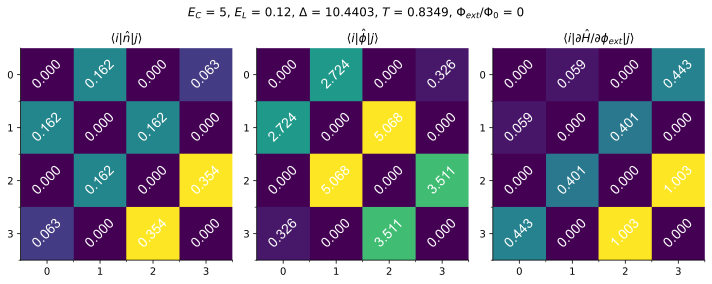

In [34]:
operators = ['n_operator', 'phase_operator','d_hamiltonian_d_phase']
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.suptitle(gatemonium._generate_suptitle(), y=0.85)  # Ajusta el valor de y según sea necesario
for idx, operator in enumerate(operators):
    gatemonium.plot_matrixelements(operator=operator,evals_count=4, show_numbers=1, fig_ax=(fig, ax[idx]), show3d=False, show_colorbar=False)
    ax[idx].set_title(rf'$ \langle i | {gatemonium.OPERATOR_LABELS[operator]} | j \rangle$')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el rect para dejar espacio al suptitle
plt.show()

## 2.2. Potential

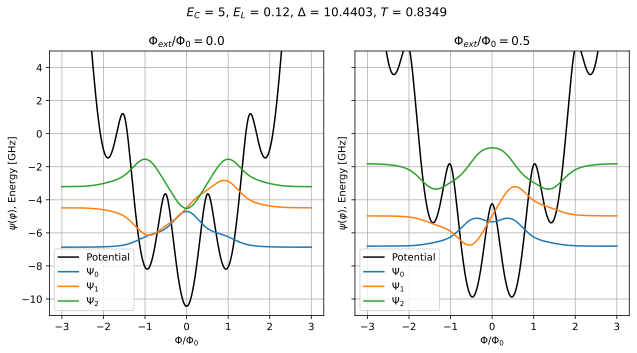

In [ ]:
%matplotlib inline
phi_array =np.linspace(-6*np.pi, 6*np.pi, 400)
fig,ax = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey=True)
fig.suptitle(gatemonium._generate_suptitle('phase'))
phases = [0, np.pi]
for idx, phase in enumerate(phases):
    gatemonium.phase = phase
    gatemonium.plot_wavefunction(which=[0, 1, 2], phi_grid=phi_array, scaling=5, fig_ax=(fig, ax[idx]))
    ax[idx].set_title(rf'$\Phi_{{ext}}/\Phi_0 = {phase/2/np.pi}$')
    ax[idx].set_ylim([-11,5])
fig.tight_layout()
plt.show()

## 2.3. Sweep 1D

In [ ]:
gatemonium.num_coef = 4
param_name = 'phase'
param_array = np.linspace(-2*np.pi, 2*np.pi, 101)
evals_count = 5
operators = ['n_operator', 'phase_operator', 'd_hamiltonian_d_phase', 'displacement_operator']
spectrum_data_gatemonium = gatemonium.get_matelements_vs_paramvals(operators, param_name, param_array, evals_count=evals_count)
spectrum_data_gatemonium = gatemonium.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium)
spectrum_data_gatemonium = gatemonium.get_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_gatemonium)

  0%|          | 0/101 [00:00<?, ?it/s]

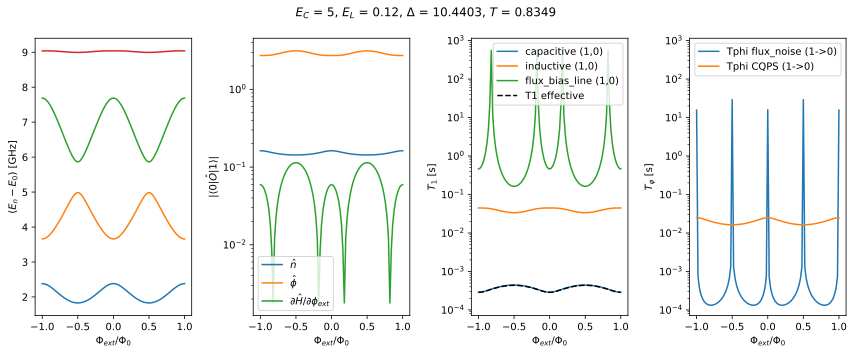

In [ ]:
subtract_ground = 1
%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle(gatemonium._generate_suptitle(exclude_params=param_name))
gatemonium.plot_evals_vs_paramvals(spectrum_data=spectrum_data_gatemonium, subtract_ground=subtract_ground, fig_ax=(fig, ax[0]), evals_count=4)
gatemonium.plot_matelem_vs_paramvals(operator='n_operator', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1]))
gatemonium.plot_matelem_vs_paramvals(operator='phase_operator', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1]))
gatemonium.plot_matelem_vs_paramvals(operator='d_hamiltonian_d_phase', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1]))
gatemonium.plot_t1_vs_paramvals(noise_channels=['capacitive', 'inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[2]))
gatemonium.plot_tphi_vs_paramvals(noise_channels='flux_noise', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[3]))
gatemonium.plot_tphi_vs_paramvals(noise_channels='CQPS', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[3]))

ax[1].set_ylabel(r'$|\langle 0 | \hat{O}| 1 \rangle|$')
ax[1].legend([r'$\hat{n}$', r'$\hat{\phi}$', r'$\partial \hat{H}/\partial \phi_{ext}$'])

if subtract_ground:
    ax[0].set_ylabel(r'$(E_n - E_0)$ [GHz]')
else:
    ax[0].set_ylabel(r'$E_n$ [GHz]')

for i in range(1, 4):
    ax[i].set_yscale('log')

# Set the same ylim for ax[2] and ax[3]
ylim_min = min(ax[2].get_ylim()[0], ax[3].get_ylim()[0])
ylim_max = max(ax[2].get_ylim()[1], ax[3].get_ylim()[1])
ax[2].set_ylim(ylim_min, ylim_max)
ax[3].set_ylim(ylim_min, ylim_max)

fig.tight_layout()
plt.show()

In [ ]:
gatemonium.phase = 0
Delta_values = np.linspace(10, 30, 30)  
T_values = np.linspace(0.7, 1, 30) 
operators = ['n_operator', 'phase_operator', 'd_hamiltonian_d_phase']
E0_array = np.empty((len(Delta_values), len(T_values)))
E1_array = np.empty((len(Delta_values), len(T_values)))
E2_array = np.empty((len(Delta_values), len(T_values)))
n_array = np.empty((len(Delta_values), len(T_values)), dtype=complex)
phase_array = np.empty((len(Delta_values), len(T_values)), dtype=complex)
dH_dphi_array = np.empty((len(Delta_values), len(T_values)), dtype=complex)
t1_cap_array = np.empty((len(Delta_values), len(T_values)))
t1_ind_array = np.empty((len(Delta_values), len(T_values)))
t1_flux_array = np.empty((len(Delta_values), len(T_values)))
t1_effective_array = np.empty((len(Delta_values), len(T_values)))

initial_param = gatemonium.Delta

for idx,Delta in enumerate(tqdm(Delta_values,leave=True)):
    gatemonium.set_param('Delta', Delta)
    param_name = "T"  # Reemplaza con el nombre del parámetro que deseas variar
    spectrum_data_gatemonium = gatemonium.get_matelements_vs_paramvals(operators, param_name, T_values, evals_count=evals_count)
    spectrum_data_gatemonium = gatemonium.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium)
    E0_array[idx] = spectrum_data_gatemonium.energy_table[:,0]
    E1_array[idx] = spectrum_data_gatemonium.energy_table[:,1]
    E2_array[idx] = spectrum_data_gatemonium.energy_table[:,2]
    t1_cap_array[idx] = spectrum_data_gatemonium.t1_table['capacitive'][:,0,1]
    t1_ind_array[idx] = spectrum_data_gatemonium.t1_table['inductive'][:,0,1]
    t1_flux_array[idx] = spectrum_data_gatemonium.t1_table['flux_bias_line'][:,0,1]
    n_array[idx] = spectrum_data_gatemonium.matrixelem_table['n_operator'][:,0,1]
    phase_array[idx] = spectrum_data_gatemonium.matrixelem_table['phase_operator'][:,0,1]
    dH_dphi_array[idx] = spectrum_data_gatemonium.matrixelem_table['d_hamiltonian_d_phase'][:,0,1]
    
gatemonium.set_param('Delta', initial_param)
    
t1_effective_array = 1/(1/t1_cap_array + 1/t1_ind_array + 1/t1_flux_array)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle(gatemonium._generate_suptitle(exclude_params=['Delta', 'T']))

# Define titles
titles = [
    r'$\left| \langle 0 | \hat{n} | 1\rangle \right|$',
    r'$\left| \langle 0 | \hat{\phi} | 1\rangle \right|$',
    r'$\left| \langle 0 | \partial\hat{H} / \partial \phi_{ext} | 1\rangle \right|$',
    r'$T_1$ Capacitive [s]',
    r'$T_1$ Inductive [s]',
    r'$T_1$ Flux Noise [s]',
    r"$T_1$ Effective [s]",
    r"$E_1 - E_0$ [GHz]",
    r"$f_{21} - f_{10}$ [GHz]"
]

# Apply titles
for i, title in enumerate(titles):
    ax[i // 3, i % 3].set_title(title)

# Find the global minimum and maximum ylim for T1 plots
t1_min = min(np.min(t1_cap_array), np.min(t1_ind_array), np.min(t1_flux_array))
t1_max = max(np.max(t1_cap_array), np.max(t1_ind_array), np.max(t1_flux_array))

# Plot data using pcolormesh
cbar0 = fig.colorbar(ax[0, 0].pcolormesh(Delta_values, T_values, np.abs(n_array), shading='auto'), ax=ax[0, 0])
cbar1 = fig.colorbar(ax[0, 1].pcolormesh(Delta_values, T_values, np.abs(phase_array), shading='auto'), ax=ax[0, 1])
cbar2 = fig.colorbar(ax[0, 2].pcolormesh(Delta_values, T_values, np.abs(dH_dphi_array), shading='auto'), ax=ax[0, 2])
cbar3 = fig.colorbar(ax[1, 0].pcolormesh(Delta_values, T_values, np.abs(t1_cap_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 0])
cbar4 = fig.colorbar(ax[1, 1].pcolormesh(Delta_values, T_values, np.abs(t1_ind_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 1])
cbar5 = fig.colorbar(ax[1, 2].pcolormesh(Delta_values, T_values, np.abs(t1_flux_array), shading='auto', norm=LogNorm(vmin=t1_min, vmax=t1_max)), ax=ax[1, 2])
cbar6 = fig.colorbar(ax[2, 0].pcolormesh(Delta_values, T_values, np.abs(t1_effective_array), shading='auto', norm=LogNorm()), ax=ax[2, 0])
cbar7 = fig.colorbar(ax[2, 1].pcolormesh(Delta_values, T_values, E1_array - E0_array, shading='auto'), ax=ax[2, 1])
cbar8 = fig.colorbar(ax[2, 2].pcolormesh(Delta_values, T_values,(E2_array -E1_array) - (E1_array - E0_array), shading='auto'), ax=ax[2, 2])

# Set common labels for all subplots
for ax_row in ax:
    for ax_col in ax_row:
        ax_col.set_xlabel(r"$\Delta$ [GHz]")
        ax_col.set_ylabel(r"$T$")
        ax_col.scatter(gatemon.Delta, gatemon.T, color='red', marker='*', s=100)  # Add a red star marker
fig.tight_layout()
plt.show()


# 3. Gatemon

In [88]:
Ec, Delta, T, n_cut, ng = 1, 45, 0.995, 10, 0.2
gatemon = Gatemon(Ec, Delta, T, ng, n_cut=n_cut)

## 3.1. Matrix elements

(<Figure size 1000x500 with 3 Axes>, (<Axes3D: >, <Axes: >))

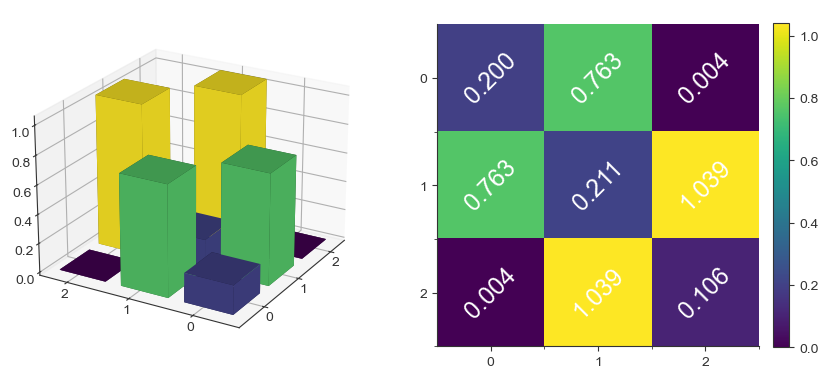

In [89]:
gatemon.plot_matrixelements(operator='n_operator', evals_count=3, show_numbers=1, show3d=1, show_colorbar=False)

## 3.2. Sweep 1D

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

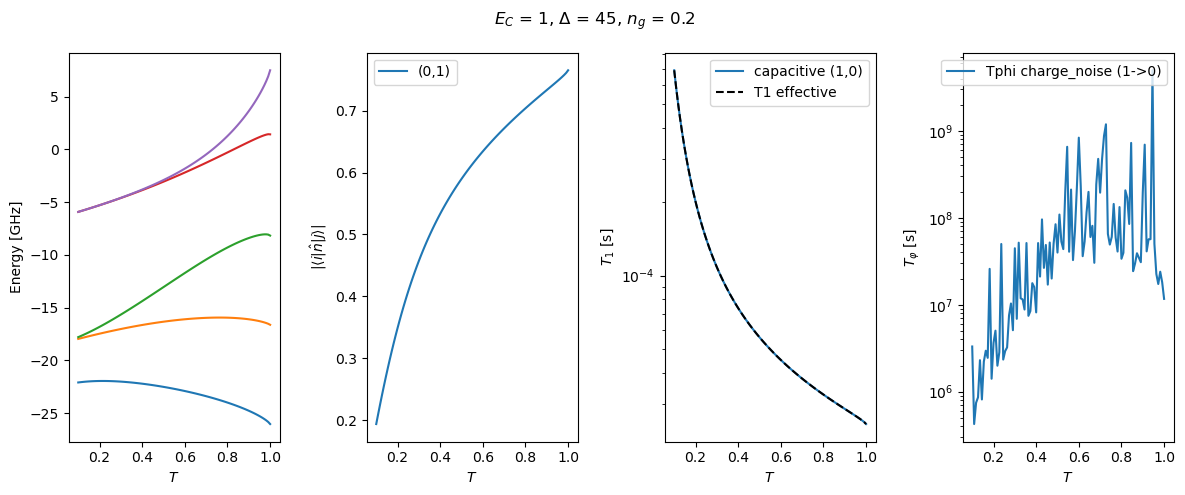

In [90]:
fig,ax = plt.subplots(1,4, figsize=(12,5))
fig.suptitle(gatemon._generate_suptitle(exclude_params='T'))
gatemon.ng = 0
gatemon.plot_evals_vs_paramvals(param_name='T', param_vals=np.linspace(0.1, 1, 100), evals_count=5, fig_ax=(fig, ax[0]))
gatemon.plot_matelem_vs_paramvals(operator='n_operator', param_name='T', param_vals=np.linspace(0.1, 1, 100), select_elems=[(0,1)], fig_ax=(fig, ax[1]))
gatemon.plot_t1_vs_paramvals(noise_channels=['capacitive'], param_name='T', param_vals=np.linspace(0.1, 1, 100), fig_ax=(fig, ax[2]))
gatemon.plot_tphi_vs_paramvals(noise_channels=['charge_noise'], param_name='T', param_vals=np.linspace(0.1, 1, 100), fig_ax=(fig, ax[3]))
ax[2].set_yscale('log')
ax[3].set_yscale('log')
fig.tight_layout()
plt.show()

# 3. Comparing Ferbo & Gatemonium

In [40]:
Ec, El, Gamma, delta_Gamma, er, phase = 5, 0.12, 10, 0, 8, 0
Delta = np.sqrt(Gamma**2 + er**2)
T = 1 - np.abs((er + 1j*delta_Gamma)/np.sqrt(Gamma**2 + er**2))**2
dimension = 100

ferbo = Ferbo(Ec, El, Gamma, delta_Gamma, er, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemon = Gatemonium(Ec, El, Delta, T, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemon.num_coef = 4

## 3.1. Potentials

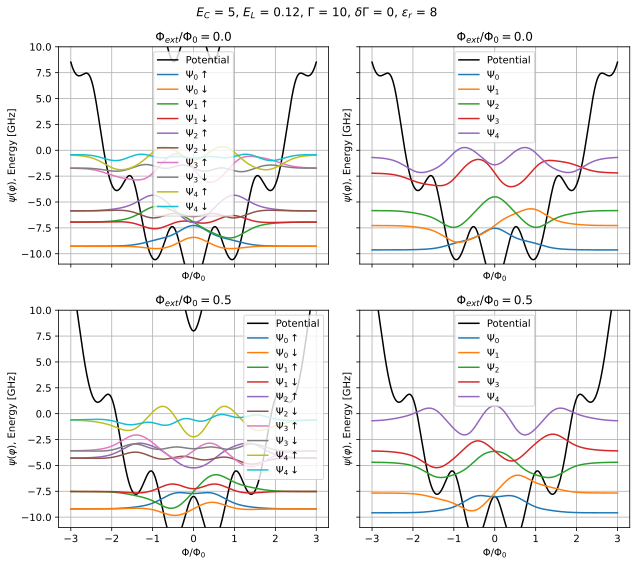

In [42]:
phi_array =np.linspace(-6*np.pi, 6*np.pi, 400)
scaling = 5
fig,ax = plt.subplots(2,2, figsize=(9,8), sharex=True, sharey=True)
fig.suptitle(ferbo._generate_suptitle('phase'))
phases = [0, np.pi]
for idx, phase in enumerate(phases):
    ferbo.phase = phase
    ferbo.plot_wavefunction(which=[0, 1, 2, 3, 4], phi_grid=phi_array, scaling=scaling, fig_ax=(fig, ax[idx,0]), basis='default')
    ax[idx,0].set_title(rf'$\Phi_{{ext}}/\Phi_0 = {phase/2/np.pi}$')
    
    gatemon.phase = phase
    gatemon.plot_wavefunction(which=[0, 1, 2, 3, 4], phi_grid=phi_array, scaling=scaling, fig_ax=(fig, ax[idx,1]))
    ax[idx,1].set_title(rf'$\Phi_{{ext}}/\Phi_0 = {phase/2/np.pi}$')
    
ax[0,0].set_ylim([-11,10])
fig.tight_layout()
plt.show()

## 3.2. Sweep 1D

In [182]:
param_name = 'delta_Gamma'
param_array = np.linspace(1, 10, 101)
evals_count = 7
operators = ['n_operator', 'phase_operator', 'd_hamiltonian_d_phase', 'displacement_operator']
spectrum_data_ferbo = ferbo.get_matelements_vs_paramvals(operators, param_name, param_array, evals_count=evals_count)
spectrum_data_ferbo = ferbo.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_ferbo)
spectrum_data_ferbo = ferbo.get_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_ferbo)

param_name = 'T'
Delta = np.sqrt(Gamma**2 + er**2)
T_values = 1 - np.abs((param_array + 1j*delta_Gamma)/np.sqrt(Gamma**2 + param_array**2))**2
param_array = T_values
evals_count = 6
spectrum_data_gatemonium = gatemon.get_matelements_vs_paramvals(operators, param_name, param_array, evals_count=evals_count)
spectrum_data_gatemonium = gatemon.get_t1_vs_paramvals(noise_channels=['capacitive','inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium)
spectrum_data_gatemonium = gatemon.get_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_gatemonium)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

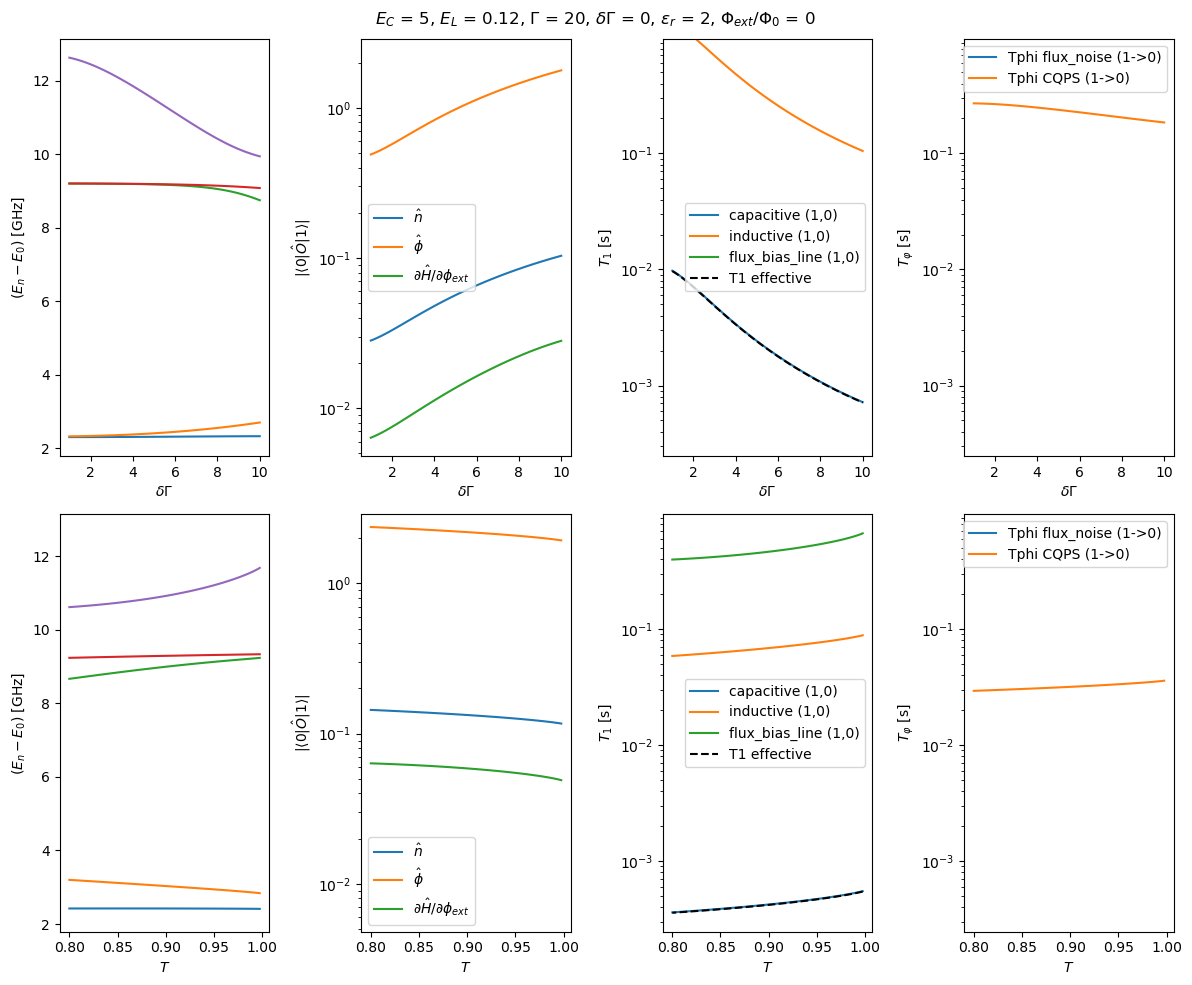

In [183]:
subtract_ground = 1

fig, ax = plt.subplots(2, 4, figsize=(12, 10))
fig.suptitle(ferbo._generate_suptitle(exclude_params=param_name))
ferbo.plot_evals_vs_paramvals(spectrum_data=spectrum_data_ferbo, subtract_ground=subtract_ground, fig_ax=(fig, ax[0,0]), evals_count=5)
ferbo.plot_matelem_vs_paramvals(operator='n_operator', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[0,1]))
ferbo.plot_matelem_vs_paramvals(operator='phase_operator', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[0,1]))
ferbo.plot_matelem_vs_paramvals(operator='d_hamiltonian_d_phase', spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[0,1]))
ferbo.plot_t1_vs_paramvals(noise_channels=['capacitive', 'inductive', 'flux_bias_line'], spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[0,2]))
ferbo.plot_tphi_vs_paramvals(noise_channels=['flux_noise', 'CQPS'], spectrum_data=spectrum_data_ferbo, fig_ax=(fig, ax[0,3]))

# fig.suptitle(gatemon._generate_suptitle(exclude_params=param_name))
gatemon.plot_evals_vs_paramvals(spectrum_data=spectrum_data_gatemonium, subtract_ground=subtract_ground, fig_ax=(fig, ax[1,0]), evals_count=5)
gatemon.plot_matelem_vs_paramvals(operator='n_operator', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,1]))
gatemon.plot_matelem_vs_paramvals(operator='phase_operator', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,1]))
gatemon.plot_matelem_vs_paramvals(operator='d_hamiltonian_d_phase', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,1]))
gatemon.plot_t1_vs_paramvals(noise_channels=['capacitive', 'inductive', 'flux_bias_line'], spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,2]))
gatemon.plot_tphi_vs_paramvals(noise_channels='flux_noise', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,3]))
gatemon.plot_tphi_vs_paramvals(noise_channels='CQPS', spectrum_data=spectrum_data_gatemonium, fig_ax=(fig, ax[1,3]))

ax[0,1].set_ylabel(r'$|\langle 0 | \hat{O}| 1 \rangle|$')
ax[0,1].legend([r'$\hat{n}$', r'$\hat{\phi}$', r'$\partial \hat{H}/\partial \phi_{ext}$'])
ax[1,1].set_ylabel(r'$|\langle 0 | \hat{O}| 1 \rangle|$')
ax[1,1].legend([r'$\hat{n}$', r'$\hat{\phi}$', r'$\partial \hat{H}/\partial \phi_{ext}$'])

if subtract_ground:
    ax[0,0].set_ylabel(r'$(E_n - E_0)$ [GHz]')
    ax[1,0].set_ylabel(r'$(E_n - E_0)$ [GHz]')
else:
    ax[0,0].set_ylabel(r'$E_n$ [GHz]')
    ax[1,0].set_ylabel(r'$E_n$ [GHz]')

for i in range(1, 4):
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    
# Set the same ylim for ax[0,2] and ax[0,3]
ylim_min = min(ax[1,2].get_ylim()[0], ax[1,3].get_ylim()[0],ax[0,2].get_ylim()[0], ax[0,3].get_ylim()[0])
ylim_max = min(ax[1,2].get_ylim()[1], ax[1,3].get_ylim()[1],max(ax[0,2].get_ylim()[1], ax[0,3].get_ylim()[1]), 1e1)
ax[0,2].set_ylim(ylim_min, ylim_max)
ax[0,3].set_ylim(ylim_min, ylim_max)
ax[1,2].set_ylim(ylim_min, ylim_max)
ax[1,3].set_ylim(ylim_min, ylim_max)

ylim_min = min(ax[0,0].get_ylim()[0], ax[1,0].get_ylim()[0])
ylim_max = max(ax[0,0].get_ylim()[1], ax[1,0].get_ylim()[1])
ax[0,0].set_ylim(ylim_min, ylim_max)
ax[1,0].set_ylim(ylim_min, ylim_max)

ylim_min = min(ax[0,1].get_ylim()[0], ax[1,1].get_ylim()[0])
ylim_max = max(ax[0,1].get_ylim()[1], ax[1,1].get_ylim()[1])
ax[0,1].set_ylim(ylim_min, ylim_max)
ax[1,1].set_ylim(ylim_min, ylim_max)

fig.tight_layout()
plt.show()

## 3.3. Differences

Differences between eigenenergies, matrix elements, and estimated decoherence

In [33]:
Ec, El, Gamma, delta_Gamma, er, phase = 2.35, 0.7, 20, 18, 10, 0
Delta = np.sqrt(Gamma**2 + er**2)
T = 1 - np.abs((er + 1j*delta_Gamma)/np.sqrt(Gamma**2 + er**2))**2
dimension = 100

ferbo = Ferbo(Ec, El, Gamma, delta_Gamma, er, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemonium = Gatemonium(Ec, El, Delta, T, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemonium.num_coef = 4

In [34]:
param_name = 'delta_Gamma'
param_vals = np.linspace(1, 18, 101)
evals_count = 4

if param_name == 'delta_Gamma':
    delta_Gamma_array = param_vals
    er_array = er * np.ones_like(param_vals)
elif param_name == 'er':
    er_array = param_vals
    delta_Gamma_array = delta_Gamma * np.ones_like(param_vals)

Delta_array = np.sqrt(Gamma**2 + er_array**2)
T_array = 1 - np.abs((er_array + 1j*delta_Gamma_array)/np.sqrt(Gamma**2 + er_array**2))**2

ferbo_eigenvals = np.empty((len(er_array), evals_count))
gatemonium_eigenvals = np.empty((len(er_array), evals_count))

ferbo_n_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
ferbo_phi_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
ferbo_dHdphi_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
ferbo_t1_capacitive_array = np.empty_like(er_array)
ferbo_t1_inductive_array = np.empty_like(er_array)
ferbo_t1_flux_bias_array = np.empty_like(er_array)
ferbo_tphi_flux_noise_array = np.empty_like(er_array)

gatemonium_n_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
gatemonium_phi_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
gatemonium_dHdphi_array = np.empty((len(er_array), evals_count, evals_count), dtype=complex)
gatemonium_t1_capacitive_array = np.empty_like(er_array)
gatemonium_t1_inductive_array = np.empty_like(er_array)
gatemonium_t1_flux_bias_array = np.empty_like(er_array)
gatemonium_tphi_flux_noise_array = np.empty_like(er_array)

for idx in tqdm(range(len(er_array))):
    ferbo.er = er_array[idx]
    ferbo.delta_Gamma = delta_Gamma_array[idx]
    gatemonium.Delta = Delta_array[idx]
    gatemonium.T = T_array[idx]
    
    ferbo_eigenvals[idx], ferbo_evecs, = ferbo.eigensys(evals_count=evals_count)
    gatemonium_eigenvals[idx], gatemonium_evecs = gatemonium.eigensys(evals_count=evals_count)
    
    ferbo_n_array[idx] = ferbo.matrixelement_table('n_operator', evecs= ferbo_evecs, evals_count=evals_count)
    ferbo_phi_array[idx] = ferbo.matrixelement_table('phase_operator',evecs= ferbo_evecs, evals_count=evals_count)
    ferbo_dHdphi_array[idx] = ferbo.matrixelement_table('d_hamiltonian_d_phase',evecs= ferbo_evecs, evals_count=evals_count)
    ferbo_t1_capacitive_array[idx] = ferbo.t1_capacitive(esys=(ferbo_eigenvals[idx], ferbo_evecs), matrix_elements=ferbo_n_array[idx])
    ferbo_t1_inductive_array[idx] = ferbo.t1_inductive(esys=(ferbo_eigenvals[idx], ferbo_evecs), matrix_elements=ferbo_phi_array[idx])
    ferbo_t1_flux_bias_array[idx] = ferbo.t1_flux_bias_line(esys=(ferbo_eigenvals[idx], ferbo_evecs), matrix_elements=ferbo_dHdphi_array[idx])
    
    gatemonium_n_array[idx] = gatemonium.matrixelement_table('n_operator', evecs= gatemonium_evecs, evals_count=evals_count)
    gatemonium_phi_array[idx] = gatemonium.matrixelement_table('phase_operator',evecs= gatemonium_evecs ,evals_count=evals_count)
    gatemonium_dHdphi_array[idx] = gatemonium.matrixelement_table('d_hamiltonian_d_phase',evecs= gatemonium_evecs, evals_count=evals_count)
    gatemonium_t1_capacitive_array[idx] = gatemonium.t1_capacitive(esys=(gatemonium_eigenvals[idx], gatemonium_evecs), matrix_elements=gatemonium_n_array[idx])
    gatemonium_t1_inductive_array[idx] = gatemonium.t1_inductive(esys=(gatemonium_eigenvals[idx], gatemonium_evecs), matrix_elements=gatemonium_phi_array[idx])
    gatemonium_t1_flux_bias_array[idx] = gatemonium.t1_flux_bias_line(esys=(gatemonium_eigenvals[idx], gatemonium_evecs), matrix_elements=gatemonium_dHdphi_array[idx])    

  0%|          | 0/101 [00:00<?, ?it/s]

TypeError: Gatemonium.d_hamiltonian_d_phase.<locals>.f() missing 1 required positional argument: 'phi_ext'

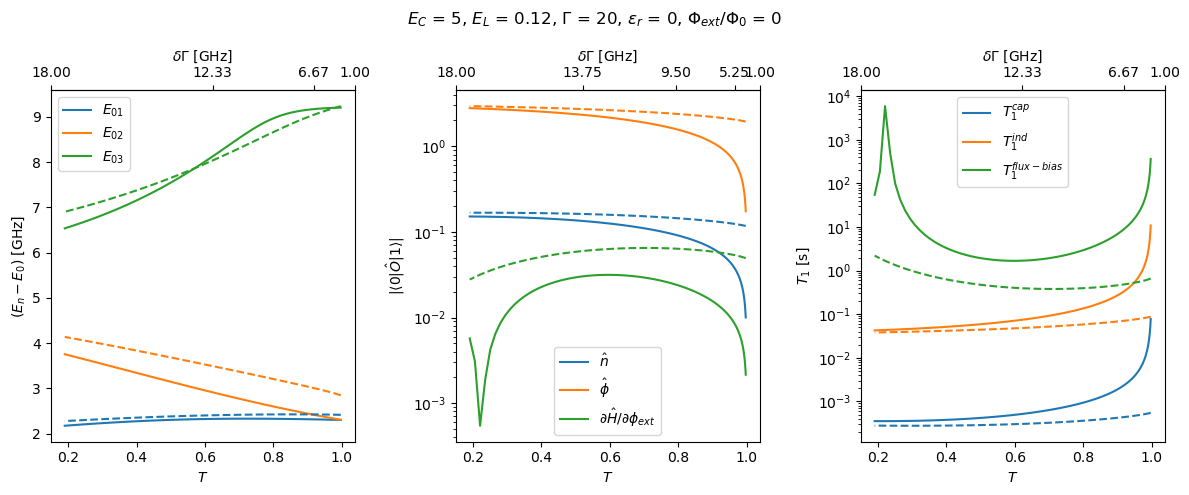

In [511]:
def forward(T):
    # Transforma T (eje inferior) a param_vals (eje superior)
    return np.interp(T, T_array, param_vals)

def inverse(param):
    # Transforma de param_vals a T
    return np.interp(param, param_vals, T_array)

fig, ax = plt.subplots(1,3, figsize= (12,5))
fig.suptitle(ferbo._generate_suptitle(exclude_params=[param_name]))

ax[0].plot(T_array, ferbo_eigenvals[:,1] - ferbo_eigenvals[:,0],color='C0')
ax[0].plot(T_array, ferbo_eigenvals[:,2] - ferbo_eigenvals[:,0], color='C1')
ax[0].plot(T_array, ferbo_eigenvals[:,3] - ferbo_eigenvals[:,0], color='C2')
ax[0].plot(T_array, gatemonium_eigenvals[:,1] - gatemonium_eigenvals[:,0], linestyle='--', color='C0')
ax[0].plot(T_array, gatemonium_eigenvals[:,2] - gatemonium_eigenvals[:,0], linestyle='--', color='C1')
ax[0].plot(T_array, gatemonium_eigenvals[:,3] - gatemonium_eigenvals[:,0], linestyle='--', color='C2')
ax[0].legend([r'$E_{01}$', r'$E_{02}$', r'$E_{03}$'])

n_ticks = 4
ax2 = ax[0].secondary_xaxis('top', functions=(forward, inverse))
param_min, param_max = np.min(param_vals), np.max(param_vals)
param_ticks = np.linspace(param_min, param_max, n_ticks)
ax2.set_xticks(param_ticks)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))
ax2.set_xlabel(rf'{ferbo.PARAM_LABELS[param_name]} [GHz]')

ax[0].set_xlabel(r'$T$')
ax[0].set_ylabel(r'$(E_{n} - E_{0})$ [GHz]')


ax[1].plot(T_array, np.abs(ferbo_n_array[:,0,1]), color='C0')
ax[1].plot(T_array, np.abs(ferbo_phi_array[:,0,1]), color='C1')
ax[1].plot(T_array, np.abs(ferbo_dHdphi_array[:,0,1]), color='C2')

ax[1].plot(T_array, np.abs(gatemonium_n_array[:,0,1]), linestyle='--', color='C0')
ax[1].plot(T_array, np.abs(gatemonium_phi_array[:,0,1]), linestyle='--', color='C1')
ax[1].plot(T_array, np.abs(gatemonium_dHdphi_array[:,0,1]), linestyle='--', color='C2')

ax[1].legend([r'$\hat{n}$', r'$\hat{\phi}$', r'$\partial \hat{H}/\partial \phi_{ext}$'])
ax[1].set_xlabel(r'$T$')
ax[1].set_ylabel(r'$|\langle 0 | \hat{O} | 1 \rangle|$')

ax2 = ax[1].secondary_xaxis('top', functions=(forward, inverse))
n_ticks = 4
param_min, param_max = np.min(param_vals), np.max(param_vals)
param_ticks = np.linspace(param_min, param_max, n_ticks)
ax2.set_xticks(param_ticks)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))
ax2.set_xlabel(rf'{ferbo.PARAM_LABELS[param_name]} [GHz]')
ax[1].set_yscale('log')


ax[2].plot(T_array, ferbo_t1_capacitive_array, color='C0')
ax[2].plot(T_array, ferbo_t1_inductive_array, color='C1')
ax[2].plot(T_array, ferbo_t1_flux_bias_array, color='C2')
ax[2].plot(T_array, gatemonium_t1_capacitive_array, color='C0', linestyle='--')
ax[2].plot(T_array, gatemonium_t1_inductive_array, color='C1', linestyle='--')
ax[2].plot(T_array, gatemonium_t1_flux_bias_array, color='C2', linestyle='--')
ax[2].set_xlabel(r'$T$')
ax[2].set_ylabel(r'$T_1$ [s]')
ax[2].set_yscale('log')
ax[2].legend([r'$T_1^{cap}$', r'$T_1^{ind}$', r'$T_1^{flux-bias}$'])

ax2 = ax[2].secondary_xaxis('top', functions=(forward, inverse))
n_ticks = 4
param_min, param_max = np.min(param_vals), np.max(param_vals)
param_ticks = np.linspace(param_min, param_max, n_ticks)
ax2.set_xticks(param_ticks)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))
ax2.set_xlabel(rf'{ferbo.PARAM_LABELS[param_name]} [GHz]')
ax[1].set_yscale('log')

fig.tight_layout()
plt.show()

# 4. Bloch treatment

In [3]:
Ec, El, Gamma, delta_Gamma, er, phase = 5, 0.12, 20, 0, 10, 0
dimension, ng, n_cut = 100, 0, 5

Delta = np.sqrt(Gamma**2 + er**2)
T = 1 - np.abs((er + 1j*delta_Gamma)/np.sqrt(Gamma**2 + er**2))**2

andreev = Andreev(Ec,Gamma,delta_Gamma,er,phase,ng,n_cut)
ferbo = Ferbo(Ec, El, Gamma, delta_Gamma, er, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemonium = Gatemonium(Ec, El, Delta, T, phase=phase, dimension=dimension, flux_grouping="ABS")
gatemon = Gatemon(Ec,Delta,T,ng,n_cut)
gatemonium.num_coef = 4
gatemon.num_coef = 4

In [4]:
gatemon_spectrum_data = gatemon.get_spectrum_vs_paramvals(param_name='ng', param_vals=np.linspace(-0.25, 0.25, 101), evals_count=5)
gatemonium_spectrum_data = gatemonium.get_spectrum_vs_paramvals(param_name='phase', param_vals=np.linspace(0, 2*np.pi, 101), evals_count=100)
andreev_spectrum_data = andreev.get_spectrum_vs_paramvals(param_name='ng', param_vals=np.linspace(-0.25, 0.25, 101), evals_count=andreev.dimension)
ferbo_spectrum_data = ferbo.get_spectrum_vs_paramvals(param_name='phase', param_vals=np.linspace(0, 2*np.pi, 101), evals_count=ferbo.dimension)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

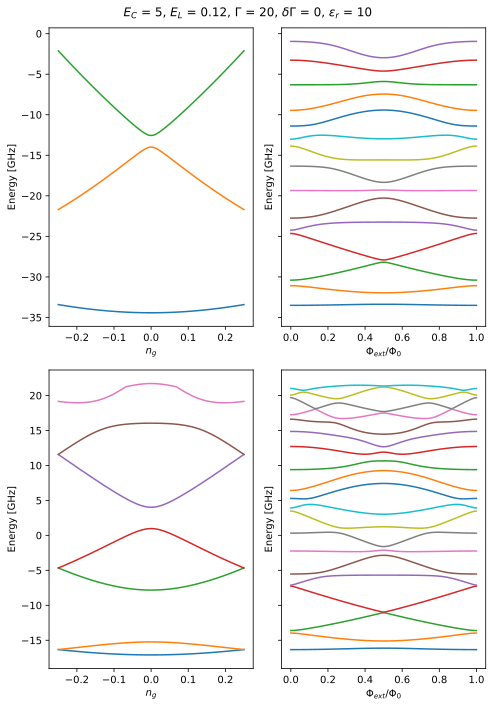

In [5]:
fig,ax = plt.subplots(2,2, figsize=(7,10),sharey="row")
fig.suptitle(ferbo._generate_suptitle(exclude_params='phase'))
gatemon.plot_evals_vs_paramvals(spectrum_data=gatemon_spectrum_data, fig_ax = (fig,ax[0,0]), evals_count=3)
gatemonium.plot_evals_vs_paramvals(spectrum_data=gatemonium_spectrum_data, fig_ax = (fig,ax[0,1]), evals_count=15)
andreev.plot_evals_vs_paramvals(spectrum_data=andreev_spectrum_data, evals_count=7, fig_ax = (fig, ax[1,0]))
ferbo.plot_evals_vs_paramvals(spectrum_data=ferbo_spectrum_data, evals_count=20, fig_ax = (fig, ax[1,1]))
fig.tight_layout()
plt.show()

# 5. Andreev 

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

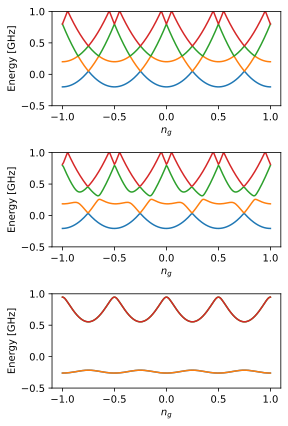

In [6]:
Ec,Gamma,delta_Gamma,er,phase,ng,n_cut = 1, 0, 0 , 0.2, 0, 0, 5
ng_vals = np.linspace(-1, 1, 201)
evals_count = 4
andreev = Andreev(Ec,Gamma,delta_Gamma,er,phase,ng,n_cut)
andreev_spectrum_data = andreev.get_spectrum_vs_paramvals(param_name='ng', param_vals=ng_vals, evals_count=andreev.dimension)
fig, ax = plt.subplots(3, 1, figsize=(4, 6))
andreev.plot_evals_vs_paramvals(spectrum_data=andreev_spectrum_data, evals_count=evals_count, fig_ax=(fig, ax[0]))

Ec,Gamma,delta_Gamma,er,phase,ng,n_cut = 1, 0.12, 0.06 , 0.2, 0, 0, 5
andreev = Andreev(Ec,Gamma,delta_Gamma,er,phase,ng,n_cut)
andreev_spectrum_data = andreev.get_spectrum_vs_paramvals(param_name='ng', param_vals=ng_vals, evals_count=andreev.dimension)
andreev.plot_evals_vs_paramvals(spectrum_data=andreev_spectrum_data, evals_count=evals_count, fig_ax=(fig, ax[1]))

Ec,Gamma,delta_Gamma,er,phase,ng,n_cut = 1, 0.8, 0 , 0, 0, 0, 5
andreev = Andreev(Ec,Gamma,delta_Gamma,er,phase,ng,n_cut)
andreev_spectrum_data = andreev.get_spectrum_vs_paramvals(param_name='ng', param_vals=ng_vals, evals_count=andreev.dimension)
andreev.plot_evals_vs_paramvals(spectrum_data=andreev_spectrum_data, evals_count=evals_count, fig_ax=(fig, ax[2]))
fig.tight_layout()

for axs in ax.flatten():
    axs.set_ylim(-0.5, 1)
plt.show()

In [7]:
def hamiltonian_charge_basis(EC, epsilon, gamma, delta, ng, nmax):
    """
    Returns a sparse representation of the Hamiltonian in the charge basis.
    """
    from scipy.sparse import diags
    N = (2 * nmax + 1)

    Gamma_L = (gamma + delta) / 2
    Gamma_R = (gamma - delta) / 2

    # Main diagonal: charging energy terms
    ns = np.arange(-nmax, nmax+1, 1, dtype=float)
    diag = 4 * EC * (ns/2 - ng)**2
    # These two lines assume nmax is even!
    diag[0::2] -= epsilon
    diag[1::2] += epsilon

    # second diagonal: Gamma_1 tunneling terms
    tunn = np.empty((N-1, ), dtype=float)
    tunn[0::2] = - Gamma_R
    tunn[1::2] = - Gamma_L

    diagonals = [tunn, diag, tunn]
    offsets = [-1, 0, 1]
    return diags(diagonals, offsets)

In [16]:
Ec = 1
Gamma = 0.1
delta_Gamma = 0.05
er = 0.
ng = 0
n_cut = 2
p = hamiltonian_charge_basis(Ec, er, Gamma, delta_Gamma, ng, n_cut)
p.toarray()

array([[ 4.   , -0.025,  0.   ,  0.   ,  0.   ],
       [-0.025,  1.   , -0.075,  0.   ,  0.   ],
       [ 0.   , -0.075,  0.   , -0.025,  0.   ],
       [ 0.   ,  0.   , -0.025,  1.   , -0.075],
       [ 0.   ,  0.   ,  0.   , -0.075,  4.   ]])

In [116]:
andreev = Andreev(Ec,Gamma,delta_Gamma,er,phase,ng,n_cut)
andreev.hamiltonian().shape

(18, 18)

In [75]:
andreev.jrl_potential()

array([[-0.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -0.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.2+0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.2+0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.2+0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
        -0.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0.2+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0